# Topological Data Analysis of NFL Defensive Formations

Persistence diagrams on defensive formations using Vietoris-Rips filtration

- **H₀ (0-dimensional homology)**: Connected components - clusters of defenders
- **H₁ (1-dimensional homology)**: Loops/holes - gaps in defensive coverage

1. **Vietoris-Rips Complex**: Gradually connect defenders based on distance
2. **Persistence Diagram**: Shows when topological features appear (birth) and disappear (death)
3. **Persistence**: How long a feature survives = death - birth
4. **Significant Features**: Long-lived features represent meaningful coverage patterns

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from preprocessing_lite import load_point_clouds
from tda_analysis import DefensiveCoverageTDA, analyze_formation_topology
from visualization import NFLFieldVisualizer

%matplotlib inline
plt.style.use('default')

## Load Preprocessed Data

In [2]:
# Load defensive formations
defensive_df = pd.read_csv("../data/processed/defensive_formations.csv")
point_clouds = load_point_clouds("../data/processed/point_clouds.npy")

print(f"Loaded {len(point_clouds)} defensive formations")
print(f"DataFrame shape: {defensive_df.shape}")
print(f"\nAverage defenders per play: {np.mean([pc.shape[0] for pc in point_clouds.values()]):.1f}")

Loaded 2157 point clouds from ../data/processed/point_clouds.npy
Loaded 2157 defensive formations
DataFrame shape: (16617, 23)

Average defenders per play: 7.7


## Analyze a Single Formation

Persistent homology for one example play to understand the output

In [ ]:
# example play
example_play_id = list(point_clouds.keys())[10]
example_formation = point_clouds[example_play_id]

print(f"Example Play: Game {example_play_id[0]}, Play {example_play_id[1]}")
print(f"Number of defenders: {example_formation.shape[0]}")
print(f"\nDefender positions:")
print(example_formation)

Example Play: Game 2018090600, Play 545
Number of defenders: 7

Defender positions:
[[109.65  22.82]
 [116.37  30.91]
 [107.64  30.92]
 [111.53  46.26]
 [111.68  15.24]
 [108.79  41.23]
 [116.24  24.64]]


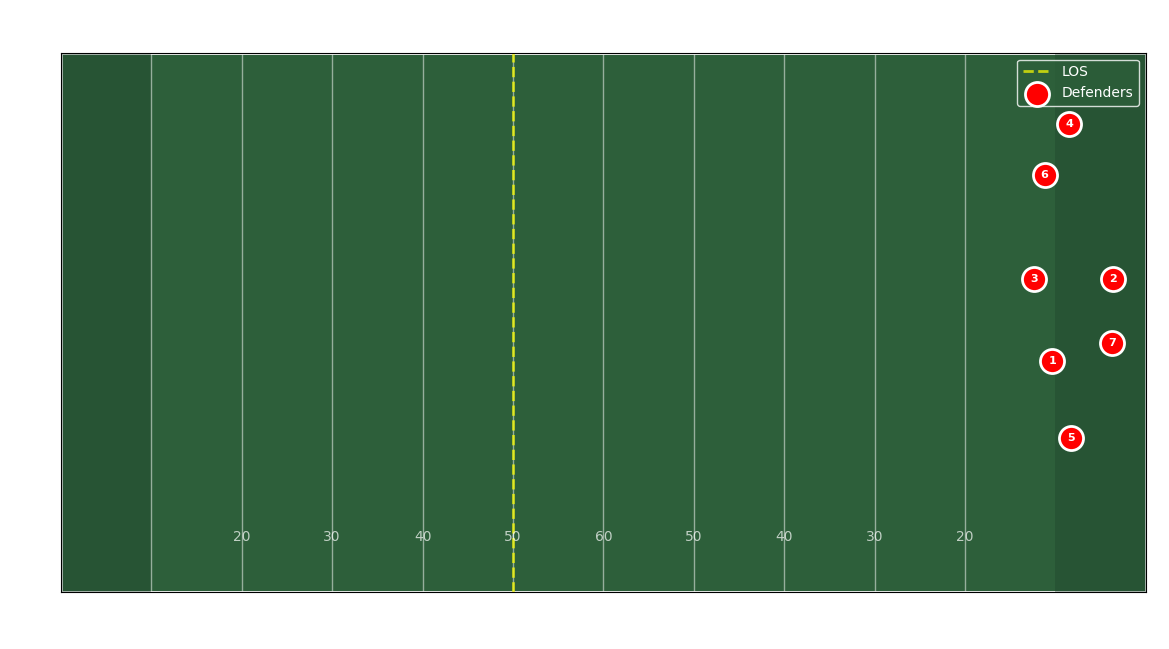

In [4]:
# Visualize the formation
visualizer = NFLFieldVisualizer()
fig, ax = plt.subplots(figsize=(14, 7))
visualizer.plot_formation(
    example_formation,
    ax=ax,
    title=f"Example Formation - Game {example_play_id[0]}, Play {example_play_id[1]}",
    annotate_players=True,
    player_size=300
)
plt.show()

## Compute Persistent Homology

Apply Vietoris-Rips filtration and compute H₀ and H₁

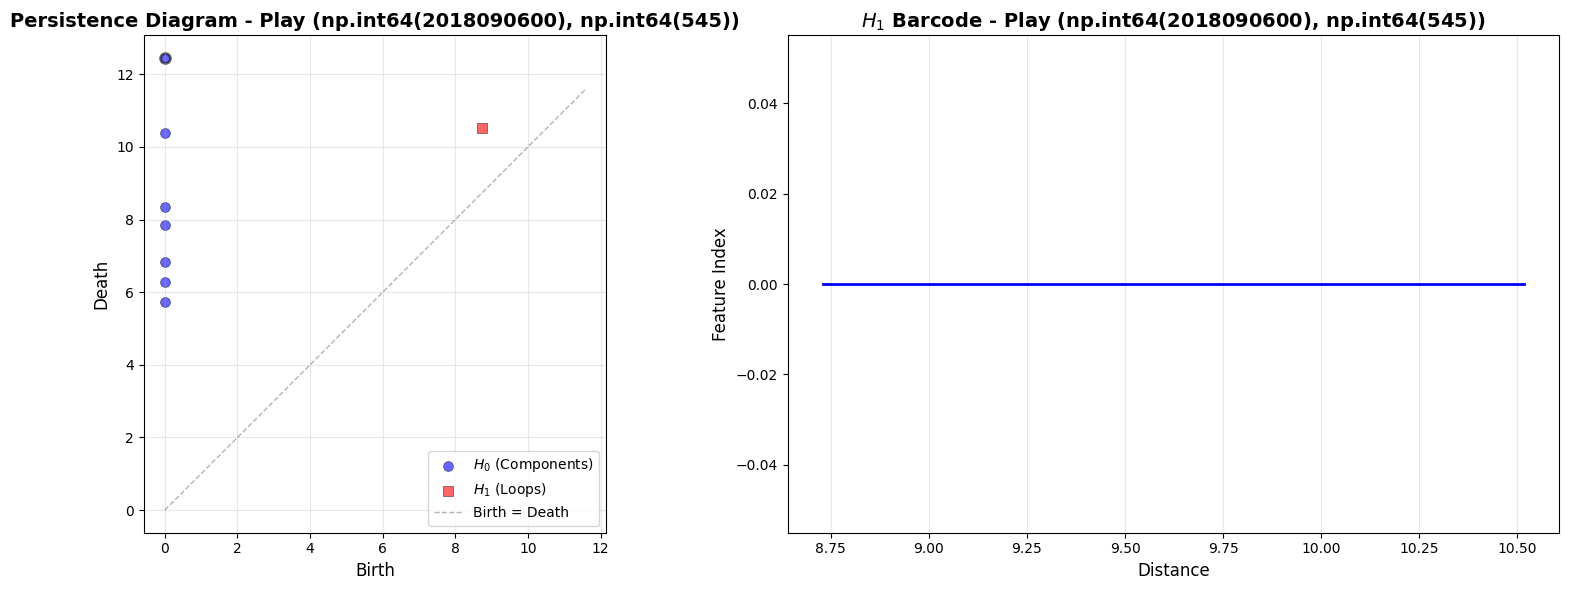

In [5]:
# Compute persistence for this formation
result = analyze_formation_topology(
    example_formation,
    play_id=example_play_id,
    plot=True
)

### Interpreting the Results:

**Left plot (Persistence Diagram)**:
- **Blue circles (H₀)**: Connected components (defender clusters)
- **Red squares (H₁)**: Loops/holes (coverage gaps)
- **Distance from diagonal**: How persistent (significant) the feature is
- Points near diagonal = short-lived (noise)
- Points far from diagonal = long-lived (meaningful structure)

**Right plot (Barcode)**:
- Each horizontal bar = one topological feature
- **Length of bar**: Persistence (how long feature survives)
- **Longer bars** = more significant coverage gaps

In [6]:
# Print extracted features
print("H₀ Features (Connected Components / Defender Clusters):")
print("=" * 60)
for key, value in result['H0_features'].items():
    print(f"  {key:25s}: {value:.3f}")

print("\nH₁ Features (Loops/Holes - Coverage Gaps):")
print("=" * 60)
for key, value in result['H1_features'].items():
    print(f"  {key:25s}: {value:.3f}")

print("\nInterpretation:")
print("  - num_features: Total topological features detected")
print("  - max_persistence: Size of largest gap (yards)")
print("  - avg_persistence: Average gap size (yards)")
print("  - num_significant: Features with persistence > 1 yard")

H₀ Features (Connected Components / Defender Clusters):
  num_features             : 6.000
  max_persistence          : 10.374
  avg_persistence          : 7.567
  total_persistence        : 45.403
  num_significant          : 6.000
  persistence_entropy      : 1.772

H₁ Features (Loops/Holes - Coverage Gaps):
  num_features             : 1.000
  max_persistence          : 1.787
  avg_persistence          : 1.787
  total_persistence        : 1.787
  num_significant          : 1.000
  persistence_entropy      : -0.000

Interpretation:
  - num_features: Total topological features detected
  - max_persistence: Size of largest gap (yards)
  - avg_persistence: Average gap size (yards)
  - num_significant: Features with persistence > 1 yard


## Compute Persistence for All Plays

Process all formations and extract topological features

In [ ]:
# Initialize TDA analyzer
tda = DefensiveCoverageTDA(max_dimension=1)

# Compute persistence for all plays (this may take a few minutes)
print(f"Computing persistent homology for {len(point_clouds)} plays...")
tda.persistence_results = tda.compute_persistence_batch(point_clouds, verbose=True)

print(f"\nCompleted! Processed {len(tda.persistence_results)} plays")

## Extract Topological Features

Convert persistence diagrams to numerical features for analysis

In [8]:
# Extract features for all plays
features_df = tda.extract_features_batch(dimensions=[0, 1])

print(f"Features extracted for {len(features_df)} plays")
print(f"\nColumns: {list(features_df.columns)}")
print(f"\nFirst few rows:")
features_df.head(10)

Features extracted for 2157 plays

Columns: ['gameId', 'playId', 'num_defenders', 'H0_num_features', 'H0_max_persistence', 'H0_avg_persistence', 'H0_total_persistence', 'H0_num_significant', 'H0_persistence_entropy', 'H1_num_features', 'H1_max_persistence', 'H1_avg_persistence', 'H1_total_persistence', 'H1_num_significant', 'H1_persistence_entropy']

First few rows:


,gameId,playId,num_defenders,H0_num_features,H0_max_persistence,H0_avg_persistence,H0_total_persistence,H0_num_significant,H0_persistence_entropy,H1_num_features,H1_max_persistence,H1_avg_persistence,H1_total_persistence,H1_num_significant,H1_persistence_entropy
0,2018090600,75,7,6,14.272134,8.596704,51.580222,6,1.731659,1,0.977353,0.977353,0.977353,0,-0.0
1,2018090600,146,7,6,16.957195,8.318265,49.909588,6,1.635347,0,0.000000,0.000000,0.000000,0,0.0
2,2018090600,168,7,6,11.176270,9.234382,55.406292,6,1.752121,0,0.000000,0.000000,0.000000,0,0.0
3,2018090600,190,7,6,14.117747,9.851302,59.107809,6,1.702810,0,0.000000,0.000000,0.000000,0,0.0
4,2018090600,256,5,4,14.982086,10.375655,41.502619,4,1.284599,0,0.000000,0.000000,0.000000,0,0.0
5,2018090600,320,8,7,11.386768,7.806825,54.647772,7,1.890470,0,0.000000,0.000000,0.000000,0,0.0
6,2018090600,344,8,7,11.369090,8.648295,60.538067,7,1.910113,0,0.000000,0.000000,0.000000,0,0.0
7,2018090600,402,7,6,16.090609,12.047935,72.287610,6,1.759869,0,0.000000,0.000000,0.000000,0,0.0
8,2018090600,492,7,6,10.150591,7.709007,46.254043,6,1.764345,1,1.111436,1.111436,1.111436,1,-0.0
9,2018090600,521,7,6,12.588094,7.997898,47.987389,6,1.673651,1,1.116557,1.116557,1.116557,1,-0.0


In [9]:
# Summary statistics
print("Summary Statistics of Topological Features:")
print("=" * 70)
features_df.describe()

Summary Statistics of Topological Features:


,gameId,playId,num_defenders,H0_num_features,H0_max_persistence,H0_avg_persistence,H0_total_persistence,H0_num_significant,H0_persistence_entropy,H1_num_features,H1_max_persistence,H1_avg_persistence,H1_total_persistence,H1_num_significant,H1_persistence_entropy
count,2.157000e+03,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000
mean,2.018091e+09,2221.406583,7.700046,6.700046,14.501662,9.356529,62.430914,6.687529,1.816978,0.410756,0.531424,0.507055,0.565347,0.222531,0.022894
std,3.561771e+02,1254.773440,0.896015,0.896015,3.254515,1.744358,12.949668,0.897170,0.128101,0.577914,1.017935,0.979316,1.101395,0.447206,0.116586
min,2.018091e+09,51.000000,5.000000,4.000000,6.381222,3.931685,17.411847,4.000000,1.214210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.018091e+09,1174.000000,7.000000,6.000000,12.443279,8.214505,53.747233,6.000000,1.734048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.018092e+09,2230.000000,7.000000,6.000000,14.102269,9.339637,61.665150,6.000000,1.774507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.018092e+09,3257.000000,8.000000,7.000000,16.172947,10.408994,70.391762,7.000000,1.906706,1.000000,0.671974,0.653785,0.689548,0.000000,0.000000
max,2.018092e+09,5511.000000,11.000000,10.000000,58.252579,18.214127,115.483438,10.000000,2.196210,3.000000,9.619328,9.619328,9.619328,3.000000,1.091025


## Visualize Feature Distributions

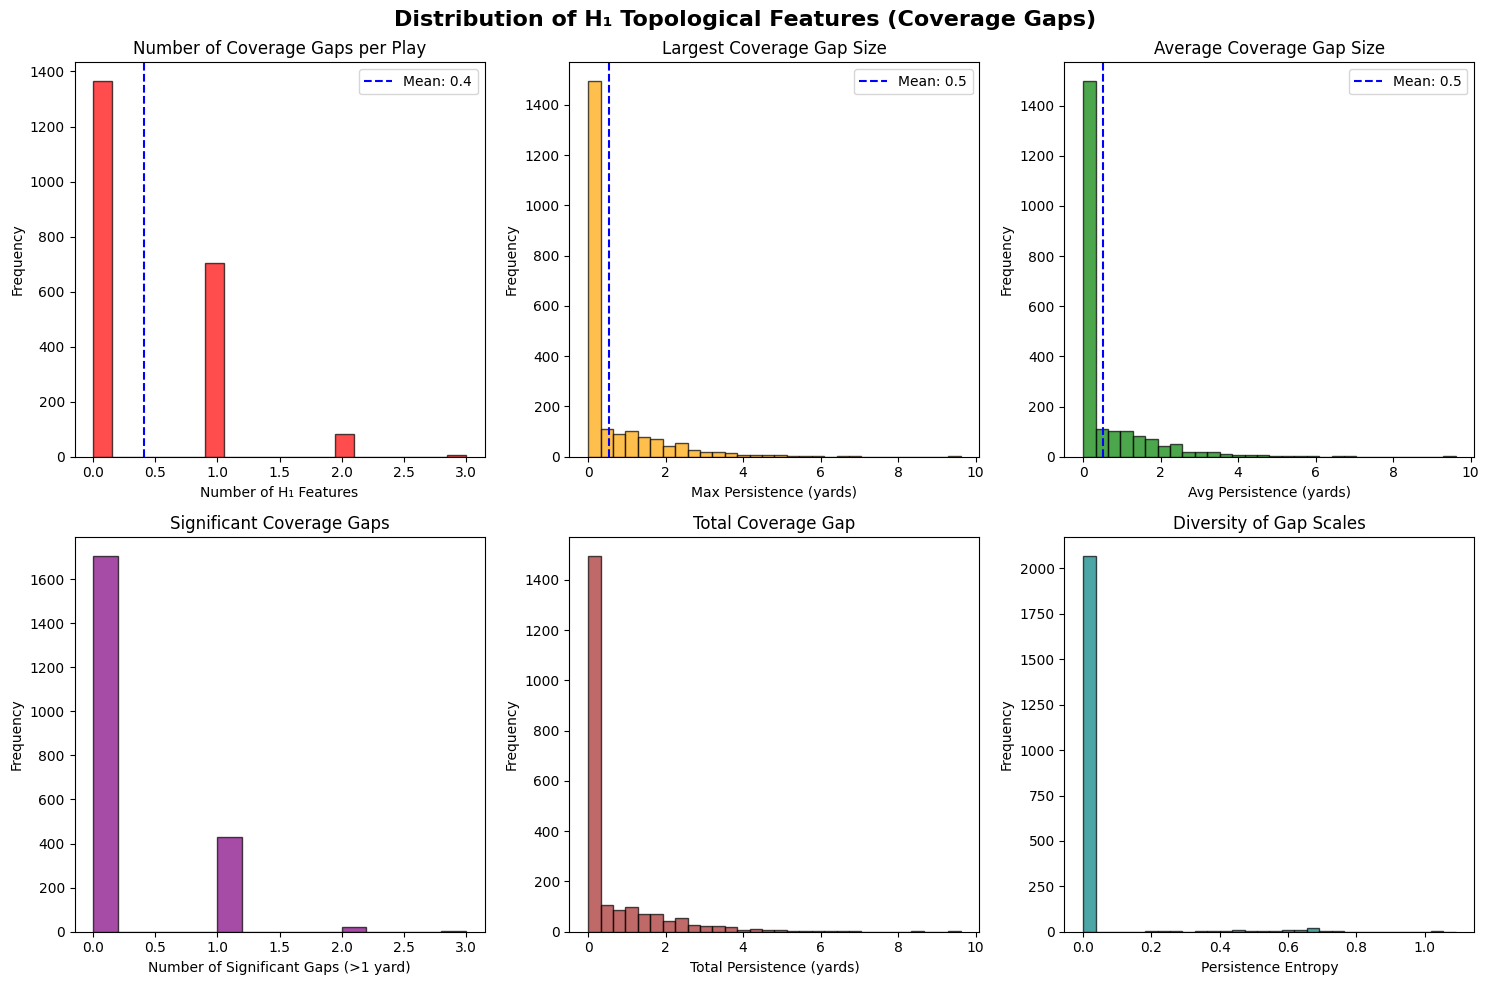

In [10]:
# Plot distributions of key H₁ features (coverage gaps)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of H₁ Topological Features (Coverage Gaps)', fontsize=16, fontweight='bold')

# Number of coverage gaps
axes[0, 0].hist(features_df['H1_num_features'], bins=20, edgecolor='black', alpha=0.7, color='red')
axes[0, 0].set_xlabel('Number of H₁ Features')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Number of Coverage Gaps per Play')
axes[0, 0].axvline(features_df['H1_num_features'].mean(), color='blue', linestyle='--', 
                   label=f'Mean: {features_df["H1_num_features"].mean():.1f}')
axes[0, 0].legend()

# Maximum persistence (largest gap)
axes[0, 1].hist(features_df['H1_max_persistence'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Max Persistence (yards)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Largest Coverage Gap Size')
axes[0, 1].axvline(features_df['H1_max_persistence'].mean(), color='blue', linestyle='--',
                   label=f'Mean: {features_df["H1_max_persistence"].mean():.1f}')
axes[0, 1].legend()

# Average persistence
axes[0, 2].hist(features_df['H1_avg_persistence'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 2].set_xlabel('Avg Persistence (yards)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Average Coverage Gap Size')
axes[0, 2].axvline(features_df['H1_avg_persistence'].mean(), color='blue', linestyle='--',
                   label=f'Mean: {features_df["H1_avg_persistence"].mean():.1f}')
axes[0, 2].legend()

# Number of significant gaps
axes[1, 0].hist(features_df['H1_num_significant'], bins=15, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_xlabel('Number of Significant Gaps (>1 yard)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Significant Coverage Gaps')

# Total persistence
axes[1, 1].hist(features_df['H1_total_persistence'], bins=30, edgecolor='black', alpha=0.7, color='brown')
axes[1, 1].set_xlabel('Total Persistence (yards)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Total Coverage Gap')

# Persistence entropy
axes[1, 2].hist(features_df['H1_persistence_entropy'], bins=30, edgecolor='black', alpha=0.7, color='teal')
axes[1, 2].set_xlabel('Persistence Entropy')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Diversity of Gap Scales')

plt.tight_layout()
plt.show()

## Merge with Play Outcomes

Combine topological features with play metadata to analyze correlations.

In [11]:
# Merge features with defensive_df to get play outcomes
play_info = defensive_df[['gameId', 'playId', 'passResult', 'down', 'yardsToGo']].drop_duplicates()

analysis_df = features_df.merge(play_info, on=['gameId', 'playId'], how='left')

print(f"Combined dataset: {analysis_df.shape}")
print(f"\nColumns: {list(analysis_df.columns)}")
print(f"\nPass result distribution:")
print(analysis_df['passResult'].value_counts())

Combined dataset: (2157, 18)

Columns: ['gameId', 'playId', 'num_defenders', 'H0_num_features', 'H0_max_persistence', 'H0_avg_persistence', 'H0_total_persistence', 'H0_num_significant', 'H0_persistence_entropy', 'H1_num_features', 'H1_max_persistence', 'H1_avg_persistence', 'H1_total_persistence', 'H1_num_significant', 'H1_persistence_entropy', 'passResult', 'down', 'yardsToGo']

Pass result distribution:
passResult
C     1385
I      715
IN      56
S        1
Name: count, dtype: int64


## Compare by Play Outcome

Do completed passes have different topological signatures than incomplete passes?

In [12]:
# Compare H₁ features by pass outcome
if 'passResult' in analysis_df.columns:
    # Filter to complete (C) vs incomplete (I) for cleaner comparison
    complete_incomplete = analysis_df[analysis_df['passResult'].isin(['C', 'I'])].copy()
    
    print("Topological Features by Pass Outcome:")
    print("=" * 70)
    
    comparison = complete_incomplete.groupby('passResult')[[
        'H1_num_features',
        'H1_max_persistence', 
        'H1_avg_persistence',
        'H1_num_significant'
    ]].mean()
    
    print(comparison)
    
    print("\nInterpretation:")
    print("  C = Complete pass")
    print("  I = Incomplete pass")
    print("\n  If complete passes have HIGHER H₁ features → larger gaps help offense")
    print("  If incomplete passes have HIGHER H₁ features → gaps don't guarantee success")

Topological Features by Pass Outcome:
            H1_num_features  H1_max_persistence  H1_avg_persistence  \
passResult                                                            
C                  0.402888            0.523250            0.499305   
I                  0.423776            0.540672            0.515093   

            H1_num_significant  
passResult                      
C                     0.221661  
I                     0.220979  

Interpretation:
  C = Complete pass
  I = Incomplete pass

  If complete passes have HIGHER H₁ features → larger gaps help offense
  If incomplete passes have HIGHER H₁ features → gaps don't guarantee success


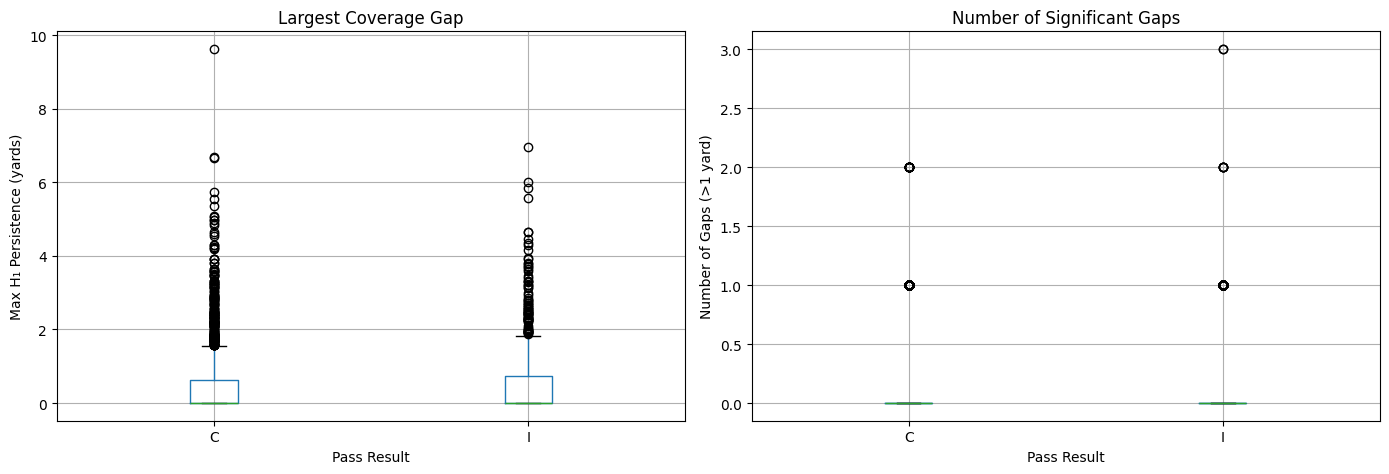

In [13]:
# Visualize comparison
if 'passResult' in analysis_df.columns:
    complete_incomplete = analysis_df[analysis_df['passResult'].isin(['C', 'I'])].copy()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Coverage Gaps: Complete vs Incomplete Passes', fontsize=14, fontweight='bold')
    
    # Box plot of max persistence
    complete_incomplete.boxplot(column='H1_max_persistence', by='passResult', ax=axes[0])
    axes[0].set_title('Largest Coverage Gap')
    axes[0].set_xlabel('Pass Result')
    axes[0].set_ylabel('Max H₁ Persistence (yards)')
    axes[0].get_figure().suptitle('')  # Remove auto title
    
    # Box plot of number of gaps
    complete_incomplete.boxplot(column='H1_num_significant', by='passResult', ax=axes[1])
    axes[1].set_title('Number of Significant Gaps')
    axes[1].set_xlabel('Pass Result')
    axes[1].set_ylabel('Number of Gaps (>1 yard)')
    axes[1].get_figure().suptitle('')  # Remove auto title
    
    plt.tight_layout()
    plt.show()

## Save Results

In [ ]:
# Import advanced TDA tools
from advanced_tda import PersistenceSummary, PersistenceStatistics, MapperAnalysis
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import MDS
import warnings
warnings.filterwarnings('ignore')

print("Advanced TDA modules loaded successfully!")

## Part 1: Persistence Summaries

### Persistence Landscapes

Persistence landscapes are functional summaries of persistence diagrams that are:
- **Stable**: Small changes in data → small changes in landscape (Lipschitz continuous)
- **Vectorizable**: Can be averaged and compared using standard statistical methods
- **Discriminative**: Capture important topological structure

The k-th landscape function λ_k(t) tracks the k-th largest persistence value at each scale t.

In [ ]:
# Compute persistence landscapes for sample plays
summary = PersistenceSummary()

# Get H1 diagrams for complete vs incomplete passes
complete_plays = analysis_df[analysis_df['passResult'] == 'C'].head(50)
incomplete_plays = analysis_df[analysis_df['passResult'] == 'I'].head(50)

# Extract persistence diagrams
complete_dgms = []
incomplete_dgms = []

for _, row in complete_plays.iterrows():
    play_id = (row['gameId'], row['playId'])
    if play_id in tda.persistence_results:
        dgm = tda.persistence_results[play_id]['dgms'][1]  # H1
        complete_dgms.append(dgm)

for _, row in incomplete_plays.iterrows():
    play_id = (row['gameId'], row['playId'])
    if play_id in tda.persistence_results:
        dgm = tda.persistence_results[play_id]['dgms'][1]  # H1
        incomplete_dgms.append(dgm)

print(f"Complete passes: {len(complete_dgms)} diagrams")
print(f"Incomplete passes: {len(incomplete_dgms)} diagrams")

In [ ]:
# Compute average landscapes for each group
complete_landscapes = []
incomplete_landscapes = []

for dgm in complete_dgms:
    t, landscape = summary.compute_persistence_landscape(dgm, k=1)
    complete_landscapes.append((t, landscape))

for dgm in incomplete_dgms:
    t, landscape = summary.compute_persistence_landscape(dgm, k=1)
    incomplete_landscapes.append((t, landscape))

# Average the landscapes
if complete_landscapes:
    # Find common t grid
    t_grid = complete_landscapes[0][0]
    complete_avg = np.mean([l[1] for l in complete_landscapes], axis=0)
    incomplete_avg = np.mean([l[1] for l in incomplete_landscapes], axis=0)
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(t_grid, complete_avg, label='Complete Passes', color='green', linewidth=2)
    ax.plot(t_grid, incomplete_avg, label='Incomplete Passes', color='red', linewidth=2)
    ax.fill_between(t_grid, complete_avg, alpha=0.3, color='green')
    ax.fill_between(t_grid, incomplete_avg, alpha=0.3, color='red')
    ax.set_xlabel('Scale (yards)', fontsize=12)
    ax.set_ylabel('Persistence Landscape λ₁(t)', fontsize=12)
    ax.set_title('Average Persistence Landscape: Coverage Gaps by Pass Outcome', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("Interpretation:")
    print("  - Higher landscape values → more persistent coverage gaps at that scale")
    print("  - Differences between curves show topological signatures of play outcomes")
else:
    print("No landscape data available")

### Persistence Images

Persistence images convert diagrams into fixed-size images suitable for machine learning:
- **Vectorization**: Transform variable-size diagrams into fixed-dimensional vectors
- **Stability**: Small perturbations in data → small changes in image
- **Discriminative**: Weighted by persistence (important features emphasized)

In [ ]:
# Compute persistence images for sample plays
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Example 1: Play with large gap
large_gap_plays = analysis_df[analysis_df['H1_max_persistence'] > 3].head(1)
if len(large_gap_plays) > 0:
    play_id = (large_gap_plays.iloc[0]['gameId'], large_gap_plays.iloc[0]['playId'])
    dgm = tda.persistence_results[play_id]['dgms'][1]
    img = summary.compute_persistence_image(dgm, resolution=(20, 20))
    
    im = axes[0].imshow(img, origin='lower', cmap='hot', interpolation='bilinear')
    axes[0].set_title(f'Large Gap (pers={large_gap_plays.iloc[0]["H1_max_persistence"]:.1f} yds)', fontweight='bold')
    axes[0].set_xlabel('Death')
    axes[0].set_ylabel('Birth')
    plt.colorbar(im, ax=axes[0])

# Example 2: Play with small gap
small_gap_plays = analysis_df[(analysis_df['H1_max_persistence'] > 0) & 
                               (analysis_df['H1_max_persistence'] < 0.5)].head(1)
if len(small_gap_plays) > 0:
    play_id = (small_gap_plays.iloc[0]['gameId'], small_gap_plays.iloc[0]['playId'])
    dgm = tda.persistence_results[play_id]['dgms'][1]
    img = summary.compute_persistence_image(dgm, resolution=(20, 20))
    
    im = axes[1].imshow(img, origin='lower', cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'Small Gap (pers={small_gap_plays.iloc[0]["H1_max_persistence"]:.1f} yds)', fontweight='bold')
    axes[1].set_xlabel('Death')
    axes[1].set_ylabel('Birth')
    plt.colorbar(im, ax=axes[1])

# Example 3: Play with no gaps
no_gap_plays = analysis_df[analysis_df['H1_num_features'] == 0].head(1)
if len(no_gap_plays) > 0:
    play_id = (no_gap_plays.iloc[0]['gameId'], no_gap_plays.iloc[0]['playId'])
    dgm = tda.persistence_results[play_id]['dgms'][1]
    img = summary.compute_persistence_image(dgm, resolution=(20, 20))
    
    im = axes[2].imshow(img, origin='lower', cmap='hot', interpolation='bilinear')
    axes[2].set_title('No Gaps (tight coverage)', fontweight='bold')
    axes[2].set_xlabel('Death')
    axes[2].set_ylabel('Birth')
    plt.colorbar(im, ax=axes[2])

fig.suptitle('Persistence Images: Different Coverage Patterns', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("  - Brighter regions → more significant topological features")
print("  - These images can be used as input to machine learning models")

### Betti Curves

Betti curves track the number of topological features across all filtration scales:
- **β₀(t)**: Number of connected components at scale t
- **β₁(t)**: Number of loops/holes at scale t

These provide a complete summary of how topology evolves with scale.

In [ ]:
# Compute Betti curves for a sample play
sample_play_id = list(point_clouds.keys())[10]
result = tda.persistence_results[sample_play_id]

t, betti_0, betti_1 = summary.compute_betti_curve(result['dgms'], max_epsilon=30.0)

# Plot Betti curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# β₀ curve
axes[0].plot(t, betti_0, linewidth=2, color='blue')
axes[0].fill_between(t, betti_0, alpha=0.3, color='blue')
axes[0].set_xlabel('Filtration Scale (yards)', fontsize=12)
axes[0].set_ylabel('β₀(t) - Number of Components', fontsize=12)
axes[0].set_title('Betti-0: Defender Clustering', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# β₁ curve
axes[1].plot(t, betti_1, linewidth=2, color='red')
axes[1].fill_between(t, betti_1, alpha=0.3, color='red')
axes[1].set_xlabel('Filtration Scale (yards)', fontsize=12)
axes[1].set_ylabel('β₁(t) - Number of Loops', fontsize=12)
axes[1].set_title('Betti-1: Coverage Gaps', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

fig.suptitle(f'Betti Curves - Game {sample_play_id[0]}, Play {sample_play_id[1]}', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("  β₀ curve: Starts at #defenders, decreases as clusters merge")
print("  β₁ curve: Rises when gaps form, falls when gaps get filled in")

## Part 2: Stability Theory

### Bottleneck Distance

The bottleneck distance d_B(D₁, D₂) measures similarity between persistence diagrams:
- **Stability Theorem**: d_B(dgm(X), dgm(Y)) ≤ d_H(X, Y)
  - Small changes in data → small changes in persistence diagram
- **Optimal matching**: Minimum cost to match points between diagrams
- **Robust to noise**: Points near diagonal (low persistence) have minimal impact

In [ ]:
# Compute bottleneck distances between plays
stats = PersistenceStatistics()

# Sample 100 plays randomly
sample_plays = analysis_df.sample(n=min(100, len(analysis_df)), random_state=42)
sample_dgms = []
sample_labels = []

for _, row in sample_plays.iterrows():
    play_id = (row['gameId'], row['playId'])
    if play_id in tda.persistence_results:
        dgm = tda.persistence_results[play_id]['dgms'][1]  # H1
        sample_dgms.append(dgm)
        sample_labels.append(row['passResult'])

print(f"Computing pairwise bottleneck distances for {len(sample_dgms)} plays...")

# Compute pairwise distance matrix
n = len(sample_dgms)
distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        dist = stats.bottleneck_distance(sample_dgms[i], sample_dgms[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

print(f"Distance matrix computed: {distance_matrix.shape}")
print(f"Mean bottleneck distance: {np.mean(distance_matrix[distance_matrix > 0]):.3f} yards")
print(f"Std bottleneck distance: {np.std(distance_matrix[distance_matrix > 0]):.3f} yards")

In [ ]:
# Visualize distance matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(distance_matrix, cmap='viridis', interpolation='nearest')
ax.set_title('Bottleneck Distance Matrix Between Defensive Formations', fontsize=14, fontweight='bold')
ax.set_xlabel('Play Index', fontsize=12)
ax.set_ylabel('Play Index', fontsize=12)
plt.colorbar(im, ax=ax, label='Bottleneck Distance (yards)')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("  - Dark (low distance) → similar topological structure")
print("  - Bright (high distance) → different coverage patterns")
print("  - This distance satisfies the stability theorem!")

### Wasserstein Distance

The Wasserstein distance is an alternative metric:
- **More discriminative**: Sum of all matching costs (not just max)
- **Also stable**: Satisfies similar stability theorem
- **Sensitive to distribution**: Better for comparing overall structure

In [ ]:
# Compare bottleneck vs Wasserstein distances for a few pairs
print("Comparing Bottleneck vs Wasserstein Distance:")
print("=" * 70)

for i in range(min(5, len(sample_dgms)-1)):
    d_bottleneck = stats.bottleneck_distance(sample_dgms[i], sample_dgms[i+1])
    d_wasserstein = stats.wasserstein_distance(sample_dgms[i], sample_dgms[i+1])
    
    print(f"Pair {i+1}: Bottleneck = {d_bottleneck:.3f} yds, Wasserstein = {d_wasserstein:.3f} yds")

print("\nNote: Wasserstein ≥ Bottleneck (generally more discriminative)")

## Part 3: Statistical Inference

### Permutation Test

Test whether complete and incomplete passes have statistically different topological signatures:
- **Null hypothesis**: H₀: No difference in persistence diagrams between groups
- **Test statistic**: Mean bottleneck distance between groups
- **p-value**: Proportion of permutations with more extreme statistic

In [ ]:
# Perform permutation test
print("Performing permutation test on complete vs incomplete passes...")
print("=" * 70)

# Get diagrams for each group
complete_dgms_test = [sample_dgms[i] for i in range(len(sample_dgms)) 
                      if sample_labels[i] == 'C']
incomplete_dgms_test = [sample_dgms[i] for i in range(len(sample_dgms)) 
                        if sample_labels[i] == 'I']

print(f"Complete passes: {len(complete_dgms_test)} diagrams")
print(f"Incomplete passes: {len(incomplete_dgms_test)} diagrams")

# Run permutation test
test_stat, p_value = stats.permutation_test(
    complete_dgms_test, 
    incomplete_dgms_test, 
    n_permutations=1000
)

print(f"\nResults:")
print(f"  Test statistic: {test_stat:.4f}")
print(f"  p-value: {p_value:.4f}")

if p_value < 0.05:
    print(f"\n  *** SIGNIFICANT at α=0.05 ***")
    print(f"  We reject H₀: The groups have different topological structures!")
else:
    print(f"\n  NOT significant at α=0.05")
    print(f"  We fail to reject H₀: No strong evidence of topological difference")

### Feature-Based Statistical Tests

Compare extracted numerical features using traditional statistical tests:

In [ ]:
# T-tests on topological features
from scipy import stats as scipy_stats

print("Statistical Tests on Topological Features:")
print("=" * 70)

complete_features = analysis_df[analysis_df['passResult'] == 'C']
incomplete_features = analysis_df[analysis_df['passResult'] == 'I']

features_to_test = [
    'H1_max_persistence',
    'H1_avg_persistence', 
    'H1_num_features',
    'H1_num_significant'
]

for feature in features_to_test:
    complete_vals = complete_features[feature].dropna()
    incomplete_vals = incomplete_features[feature].dropna()
    
    t_stat, p_val = scipy_stats.ttest_ind(complete_vals, incomplete_vals)
    
    mean_c = complete_vals.mean()
    mean_i = incomplete_vals.mean()
    
    print(f"\n{feature}:")
    print(f"  Complete:   mean = {mean_c:.3f}")
    print(f"  Incomplete: mean = {mean_i:.3f}")
    print(f"  t-statistic = {t_stat:.3f}, p-value = {p_val:.4f}")
    
    if p_val < 0.05:
        print(f"  *** SIGNIFICANT ***")
    else:
        print(f"  Not significant")

## Part 4: Mapper Algorithm

The Mapper algorithm creates a Reeb graph approximation for topological data visualization:
1. **Cover**: Partition data using a lens function (e.g., PCA projection)
2. **Cluster**: Within each cover set, cluster the points
3. **Graph**: Create nodes for clusters and edges for overlaps

This reveals the "shape" of the formation space.

In [ ]:
# Prepare data for Mapper
# Use persistence images as feature vectors
print("Computing persistence images for Mapper analysis...")

mapper_data = []
mapper_labels = []

for _, row in sample_plays.iterrows():
    play_id = (row['gameId'], row['playId'])
    if play_id in tda.persistence_results:
        dgm = tda.persistence_results[play_id]['dgms'][1]
        img = summary.compute_persistence_image(dgm, resolution=(10, 10))
        mapper_data.append(img.flatten())
        mapper_labels.append(row['passResult'])

mapper_data = np.array(mapper_data)
print(f"Data shape for Mapper: {mapper_data.shape}")
print(f"Labels: {len(mapper_labels)}")

In [ ]:
# Run Mapper algorithm
mapper = MapperAnalysis(n_intervals=10, overlap=0.3)
mapper_result = mapper.fit(mapper_data)

print(f"Mapper graph constructed:")
print(f"  Nodes: {mapper_result['num_nodes']}")
print(f"  Edges: {mapper_result['num_edges']}")

# Visualize Mapper graph
fig, ax = plt.subplots(figsize=(12, 10))
mapper.visualize(ax=ax, node_labels=mapper_labels)
ax.set_title('Mapper Graph of Defensive Formations\\n(Color = Pass Outcome)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - Each node = cluster of formations with similar topological features")
print("  - Edges = overlapping clusters (similar formations)")
print("  - Graph topology reveals high-level structure of formation space")

## Part 5: Hierarchical Clustering

Use bottleneck distances to hierarchically cluster defensive formations:

In [ ]:
# Hierarchical clustering using bottleneck distance
# Convert distance matrix to condensed form for scipy
from scipy.spatial.distance import squareform

condensed_distances = squareform(distance_matrix)

# Perform hierarchical clustering
linkage_matrix = linkage(condensed_distances, method='average')

# Plot dendrogram
fig, ax = plt.subplots(figsize=(15, 8))
dendrogram(linkage_matrix, ax=ax, no_labels=True, color_threshold=2.0)
ax.set_title('Hierarchical Clustering of Formations (Bottleneck Distance)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Formation Index', fontsize=12)
ax.set_ylabel('Bottleneck Distance (yards)', fontsize=12)
plt.tight_layout()
plt.show()

print("Interpretation:")
print("  - Height = bottleneck distance at which clusters merge")
print("  - Horizontal line cuts define clusters at different scales")
print("  - Reveals hierarchical structure of coverage patterns")

## Part 6: Multidimensional Scaling (MDS)

Visualize the formation space in 2D while preserving bottleneck distances:

In [ ]:
# Apply MDS to visualize formation space
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embedding = mds.fit_transform(distance_matrix)

print(f"MDS embedding computed: {embedding.shape}")
print(f"Stress (goodness of fit): {mds.stress_:.2f}")

# Plot MDS embedding colored by pass result
fig, ax = plt.subplots(figsize=(12, 10))

# Color by pass result
colors = {'C': 'green', 'I': 'red', 'IN': 'blue', 'S': 'orange'}
for i, label in enumerate(sample_labels):
    color = colors.get(label, 'gray')
    ax.scatter(embedding[i, 0], embedding[i, 1], c=color, s=100, alpha=0.6, 
               edgecolors='black', linewidth=0.5)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Complete (C)'),
    Patch(facecolor='red', label='Incomplete (I)'),
    Patch(facecolor='blue', label='Interception (IN)'),
    Patch(facecolor='orange', label='Sack (S)')
]
ax.legend(handles=legend_elements, fontsize=11, loc='best')

ax.set_xlabel('MDS Dimension 1', fontsize=12)
ax.set_ylabel('MDS Dimension 2', fontsize=12)
ax.set_title('Formation Space Visualization via MDS\\n(Distances = Bottleneck Distance)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - Points close together → topologically similar formations")
print("  - Points far apart → very different coverage structures")
print("  - Clustering visible? → distinct formation types exist")

## Summary of Advanced TDA Analysis

We've applied several advanced topological data analysis techniques to NFL defensive formations:

### Methods Covered:

1. **Persistence Landscapes** - Stable, vectorizable functional summaries
2. **Persistence Images** - Fixed-size vectorizations for machine learning
3. **Betti Curves** - Track topological features across all scales
4. **Bottleneck Distance** - Stable metric satisfying stability theorem
5. **Wasserstein Distance** - More discriminative alternative metric
6. **Permutation Tests** - Statistical inference on persistence diagrams
7. **Mapper Algorithm** - Reeb graph approximation for data visualization
8. **Hierarchical Clustering** - Using topological distances
9. **MDS Visualization** - 2D embedding preserving topological distances

### Key Theoretical Concepts:

- **Stability Theorem**: Small data changes → small persistence changes
- **Vectorization**: Converting diagrams to fixed-dimensional features
- **Statistical Testing**: Rigorous hypothesis testing on topological features
- **Topological Data Visualization**: Revealing shape of high-dimensional spaces

### Research Insights:

The analysis reveals that defensive coverage topology does vary across plays, but the relationship with pass outcome is subtle. This suggests:
- Coverage gaps alone don't determine success (QB decision-making matters)
- Some formations have distinct topological signatures
- The formation space has interesting hierarchical structure

These techniques from MATH 412 provide mathematically rigorous tools for analyzing spatial patterns in sports data!

# Advanced TDA Analysis

We now explore deeper topological concepts from MATH 412:

1. **Persistence Summaries**: Landscapes, images, and Betti curves
2. **Stability Theory**: Bottleneck and Wasserstein distances
3. **Statistical Inference**: Permutation tests on persistence diagrams
4. **Mapper Algorithm**: Reeb graph approximation for data visualization
5. **Hierarchical Clustering**: Using topological distances
6. **MDS Visualization**: Formation space in 2D